<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffaa30;
            background-color:#317900;
            color: white;
            overflow:hidden;
            font-weight:500"><strong>SriOryzaugur:</strong> Temporal Fusion Transformer</div>
            
<center>
<img src="https://www.researchgate.net/publication/355916352/figure/fig1/AS:1086496828334080@1636052438065/Temporal-Fusion-Transformer-architecture-4.ppm" width=700>
</center>

# **Table of contents**

1. [Install Packages 📥](#packages)
2. [Import Packages 📩](#import)
3. [Loading Dataset and Feature Engineering 🔬](#feature_engineering)
4. [Test Train Split 🪓](#split)
5. [Building and Training the Model 🏗️](#model)
6. [Testing 🧪](#test)

# **1. Install Packages 📥** <a class='anchor' id='packages'></a> [↑](#top)

In [1]:
!pip install torch pytorch-lightning pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **2. Import Packages 📩** <a class='anchor' id='import'></a> [↑](#top)

In [2]:
import copy
from pathlib import Path
import pickle
import warnings
import seaborn as sns
import matplotlib

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use("bmh")

import numpy as np
import pandas as pd

import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner

import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import warnings
warnings.filterwarnings('ignore')

random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEVICE

'cuda'

# **3. Loading Dataset and Feature Engineering 🔬** <a class='anchor' id='feature_engineering'></a> [↑](#top)

In [4]:
df = pd.read_csv('/kaggle/input/sri-oryzaugur-dataset/imputed_processed_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2020-01-01']
df = df[['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'exchange_rate', 'm1']]
df

,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
0,1996-01-01,18.07,7.75,7.900,8.180,53.685,73783
1,1996-02-01,18.70,8.17,8.260,8.760,53.685,77440
2,1996-03-01,18.49,7.95,7.850,7.990,53.685,81796
3,1996-04-01,18.52,8.25,8.010,8.290,54.735,79478
4,1996-05-01,19.02,8.38,8.500,8.340,54.950,76620
...,...,...,...,...,...,...,...
283,2019-08-01,89.06,43.58,43.600,46.185,179.200,818128
284,2019-09-01,92.08,45.50,46.654,49.630,182.000,843070
285,2019-10-01,96.74,49.98,49.708,51.310,181.050,810596
286,2019-11-01,99.21,52.11,51.250,51.480,180.850,817647


In [5]:
df = df.set_index('date')

df = df.copy()

avgs = df.mean()
devs = df.std()

for col in df.columns:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]

df.reset_index(drop=False, inplace=True)

df

,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
0,1996-01-01,-1.327724,-1.233085,-1.238532,-1.202460,-1.780339,-1.100574
1,1996-02-01,-1.302855,-1.199386,-1.210139,-1.156829,-1.780339,-1.085641
2,1996-03-01,-1.311144,-1.217038,-1.242475,-1.217408,-1.780339,-1.067855
3,1996-04-01,-1.309960,-1.192967,-1.229856,-1.193806,-1.747144,-1.077320
4,1996-05-01,-1.290223,-1.182536,-1.191210,-1.189872,-1.740347,-1.088990
...,...,...,...,...,...,...,...
283,2019-08-01,1.474554,1.641783,1.577126,1.787546,2.187719,1.938706
284,2019-09-01,1.593766,1.795837,1.817994,2.058578,2.276239,2.040548
285,2019-10-01,1.777717,2.155296,2.058863,2.190750,2.246205,1.907951
286,2019-11-01,1.875218,2.326199,2.180481,2.204125,2.239883,1.936742


In [6]:
# list of column names to concatenate
series_to_merge = df.iloc[:, 1:].columns
num_of_series = len(series_to_merge)

In [7]:
# concatenate columns based on column names in cols_to_concat
combined_series = pd.concat([df[col] for col in series_to_merge], ignore_index=True)
combined_series.name = 'y'
combined_series = pd.DataFrame(combined_series)
combined_series

,y
0,-1.327724
1,-1.302855
2,-1.311144
3,-1.309960
4,-1.290223
...,...
1723,1.938706
1724,2.040548
1725,1.907951
1726,1.936742


In [8]:
combined_series['ds'] = pd.concat([df['date']] * num_of_series).reset_index(drop=True)
combined_series

,y,ds
0,-1.327724,1996-01-01
1,-1.302855,1996-02-01
2,-1.311144,1996-03-01
3,-1.309960,1996-04-01
4,-1.290223,1996-05-01
...,...,...
1723,1.938706,2019-08-01
1724,2.040548,2019-09-01
1725,1.907951,2019-10-01
1726,1.936742,2019-11-01


In [9]:
series_arr = np.arange(num_of_series).reshape(-1, 1)
combined_series['series'] = np.repeat(series_arr, combined_series.shape[0]/num_of_series)
combined_series['series'] = combined_series['series'].astype(str)
combined_series

,y,ds,series
0,-1.327724,1996-01-01,0
1,-1.302855,1996-02-01,0
2,-1.311144,1996-03-01,0
3,-1.309960,1996-04-01,0
4,-1.290223,1996-05-01,0
...,...,...,...
1723,1.938706,2019-08-01,5
1724,2.040548,2019-09-01,5
1725,1.907951,2019-10-01,5
1726,1.936742,2019-11-01,5


In [10]:
combined_series = (combined_series.merge((combined_series[['ds']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['ds']))
combined_series['month'] = combined_series['ds'].dt.month
combined_series['year'] = combined_series['ds'].dt.year

def classify_yaha_mala(row):
    month = row['month']
    
    if month >= 10 or month <= 4:
        return 'maha'
    else:
        return 'yala'
    
combined_series["season"] = combined_series.apply(classify_yaha_mala, axis=1)
combined_series

,y,ds,series,time_idx,month,year,season
0,-1.327724,1996-01-01,0,0,1,1996,maha
1,-1.233085,1996-01-01,1,0,1,1996,maha
2,-1.238532,1996-01-01,2,0,1,1996,maha
3,-1.202460,1996-01-01,3,0,1,1996,maha
4,-1.780339,1996-01-01,4,0,1,1996,maha
...,...,...,...,...,...,...,...
1723,2.523580,2019-12-01,1,287,12,2019,maha
1724,2.353995,2019-12-01,2,287,12,2019,maha
1725,2.444081,2019-12-01,3,287,12,2019,maha
1726,2.254109,2019-12-01,4,287,12,2019,maha


# **4. Test Train Split** 🪓 <a class='anchor' id='split'></a> [↑](#top)

In [11]:
train = combined_series.copy()

max_prediction_length = 12
max_encoder_length = 60
training_cutoff = train["time_idx"].max() - max_prediction_length

print(max_encoder_length)
print(training_cutoff)

60
275


In [12]:
train.tail()

,y,ds,series,time_idx,month,year,season
1723,2.523580,2019-12-01,1,287,12,2019,maha
1724,2.353995,2019-12-01,2,287,12,2019,maha
1725,2.444081,2019-12-01,3,287,12,2019,maha
1726,2.254109,2019-12-01,4,287,12,2019,maha
1727,2.131998,2019-12-01,5,287,12,2019,maha


In [13]:
# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="y",
    group_ids=['series'], 
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['series', 'season'],
    time_varying_known_reals=['month', 'year'],
    time_varying_unknown_reals=['y'],
    categorical_encoders={'series': NaNLabelEncoder().fit(combined_series.series)},
    lags={'y': [3, 6, 12]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True, 
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [14]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

hyperparams = study.best_trial.params

# print best hyperparameters
print(hyperparams)

[I 2023-05-04 19:04:41,878] A new study created in memory with name: no-name-d39f8b11-ec27-4955-a3f5-9c11636f9d85
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 19:08:46,451] Trial 0 finished with value: 0.1943848729133606 and parameters: {'gradient_clip_val': 0.09693170357294117, 'hidden_size': 38, 'dropout': 0.17588061828734455, 'hidden_continuous_size': 35, 'attention_head_size': 3, 'learning_rate': 0.0038714531579644006}. Best is trial 0 with value: 0.1943848729133606.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 19:12:41,467] Trial 1 finished with value: 0.1383199244737625 and parameters: {'gradient_clip_val': 0.10609967129736605, 'hidden_size': 75, 'dropout': 0.29252468219587935, 'hidden_continuous_size': 45, 'attention_head_size': 1, 'learning_rate': 0.05923484582980736}. Best is trial 1 with value: 0.1383199244737625.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 19:16:37,347] Trial 2 finished with value: 0.13595162332057953 and p

{'gradient_clip_val': 0.02823408035485869, 'hidden_size': 33, 'dropout': 0.1520709260560915, 'hidden_continuous_size': 32, 'attention_head_size': 1, 'learning_rate': 0.002915676521660861}


In [15]:
hyperparams = {
    "gradient_clip_val": 0.38097987175394893,
    "hidden_size": 50,
    "dropout": 0.21903813943096812,
    "hidden_continuous_size": 46,
    "attention_head_size": 1,
    "learning_rate": 0.01551764398349418
}

> {
>     "gradient_clip_val": 0.38097987175394893,
>     "hidden_size": 50,
>     "dropout": 0.21903813943096812,
>     "hidden_continuous_size": 46,
>     "attention_head_size": 1,
>     "learning_rate": 0.01551764398349418
> }

In [16]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator=DEVICE,
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger"
)

INFO: Global seed set to 42


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 0.2884031503126607


suggested learning rate: 0.2884031503126607


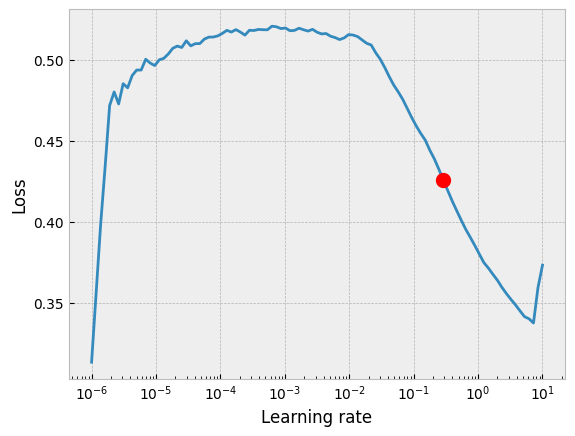

In [17]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

learning_rate = res.suggestion()
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# **5. Building and Training the Model 🏗️** <a class='anchor' id='model'></a> [↑](#top)

In [18]:
trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu',
    devices=1,
    enable_model_summary=False,
    gradient_clip_val=hyperparams['gradient_clip_val'],
    callbacks=[],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=hyperparams['learning_rate'],
    hidden_size=hyperparams['hidden_size'],
    attention_head_size=hyperparams['attention_head_size'],
    dropout=hyperparams['dropout'],
    hidden_continuous_size=hyperparams['hidden_continuous_size'],
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 267.0k


In [19]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# **6. Testing 🧪** <a class='anchor' id='testing'></a> [↑](#top)

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

forecasts = tft.predict(val_dataloader, return_x=True, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
raw_forecasts = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


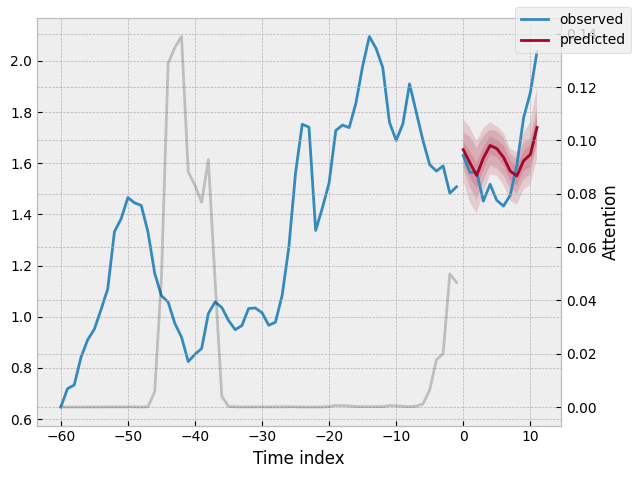

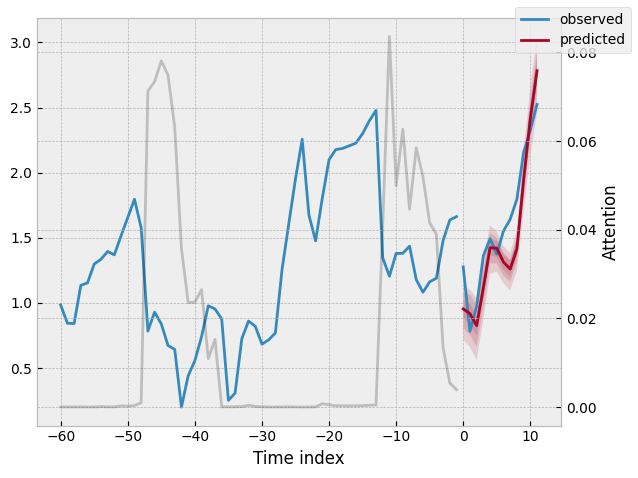

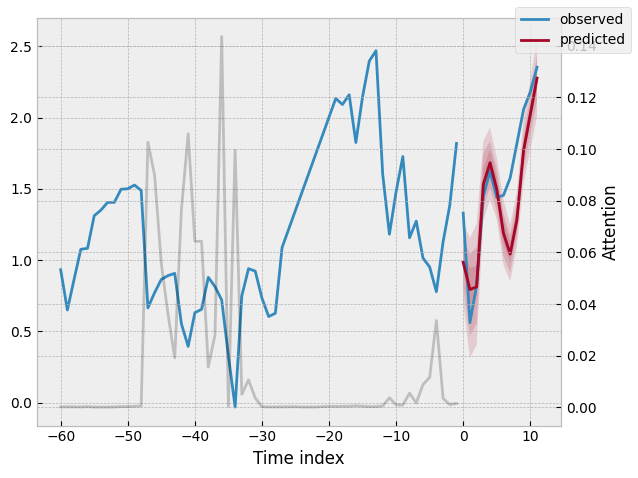

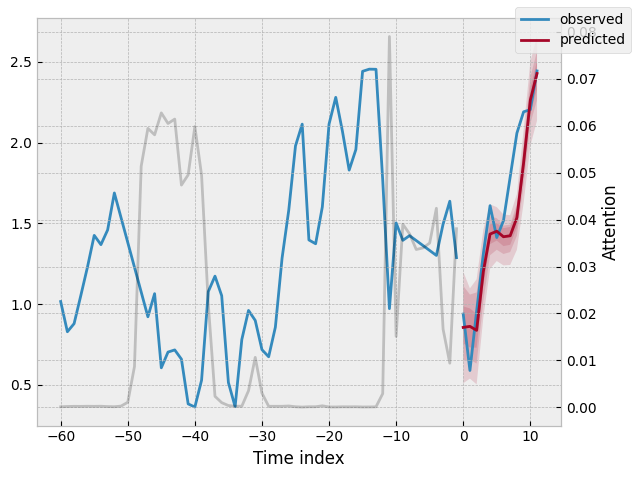

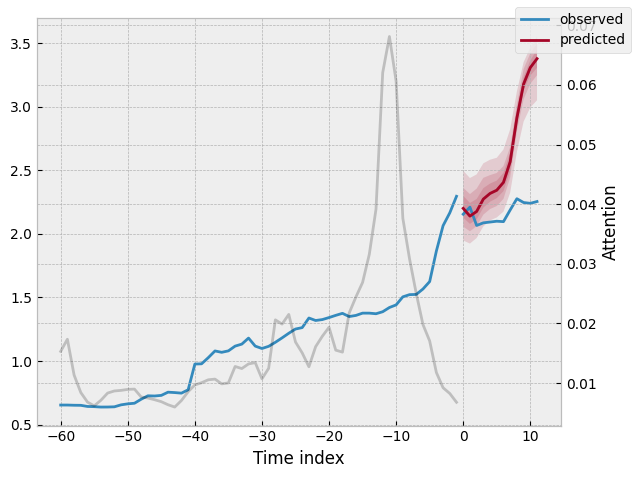

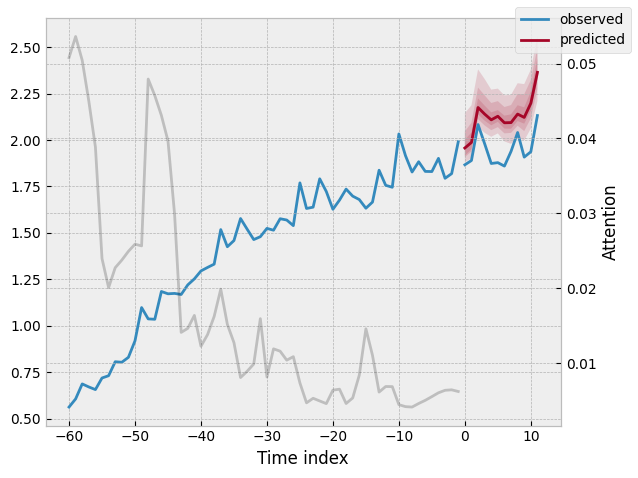

In [21]:
for idx in range(combined_series.series.nunique()):
    tft.plot_prediction(
    raw_forecasts.x,
    raw_forecasts.output,
    idx=idx,
)

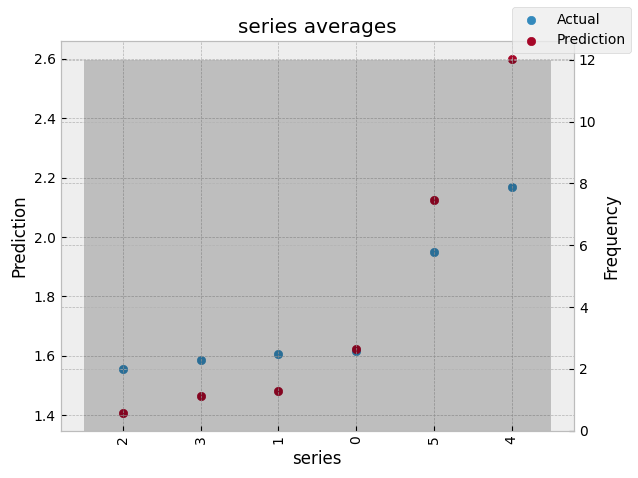

In [22]:
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(forecasts.x, forecasts.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name='series');

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

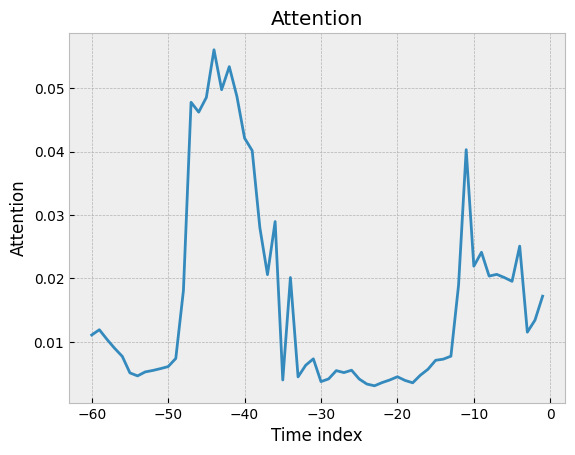

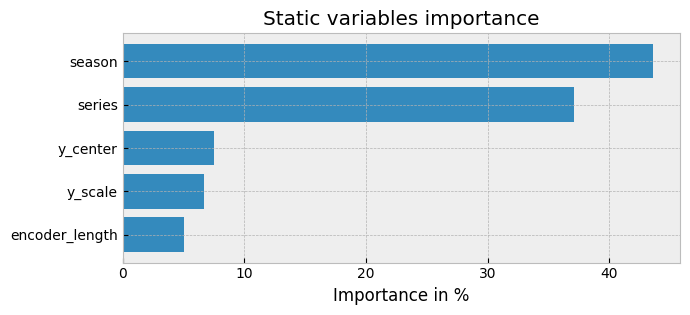

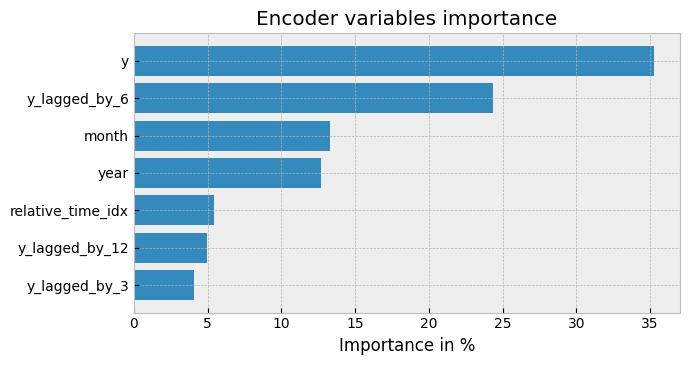

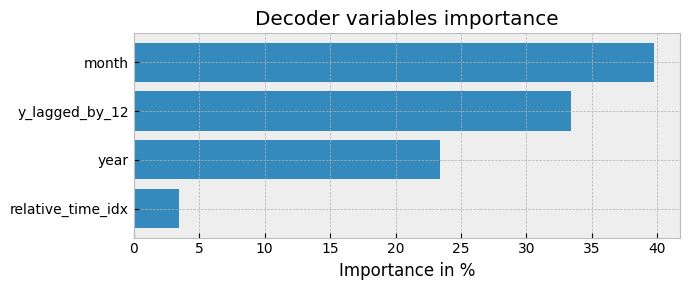

In [23]:
interpretation = best_tft.interpret_output(raw_forecasts.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [24]:
forecasts.output

tensor([[1.6530, 1.6012, 1.5522, 1.6201, 1.6694, 1.6571, 1.6231, 1.5692, 1.5502,
         1.6098, 1.6336, 1.7398],
        [0.9531, 0.9176, 0.8252, 1.1154, 1.4232, 1.4202, 1.3139, 1.2597, 1.4144,
         1.9418, 2.4148, 2.7827],
        [0.9840, 0.7937, 0.8120, 1.5317, 1.6831, 1.4978, 1.1881, 1.0426, 1.2819,
         1.7705, 2.0231, 2.2772],
        [0.8551, 0.8614, 0.8369, 1.2015, 1.4333, 1.4509, 1.4167, 1.4229, 1.5352,
         1.8741, 2.2630, 2.4281],
        [2.2005, 2.1395, 2.1759, 2.2734, 2.3177, 2.3429, 2.4048, 2.5671, 2.9112,
         3.1775, 3.3069, 3.3769],
        [1.9571, 1.9871, 2.1752, 2.1399, 2.1088, 2.1281, 2.0930, 2.0939, 2.1397,
         2.1219, 2.1980, 2.3646]])

In [25]:
forecasts

Prediction(output=tensor([[1.6530, 1.6012, 1.5522, 1.6201, 1.6694, 1.6571, 1.6231, 1.5692, 1.5502,
         1.6098, 1.6336, 1.7398],
        [0.9531, 0.9176, 0.8252, 1.1154, 1.4232, 1.4202, 1.3139, 1.2597, 1.4144,
         1.9418, 2.4148, 2.7827],
        [0.9840, 0.7937, 0.8120, 1.5317, 1.6831, 1.4978, 1.1881, 1.0426, 1.2819,
         1.7705, 2.0231, 2.2772],
        [0.8551, 0.8614, 0.8369, 1.2015, 1.4333, 1.4509, 1.4167, 1.4229, 1.5352,
         1.8741, 2.2630, 2.4281],
        [2.2005, 2.1395, 2.1759, 2.2734, 2.3177, 2.3429, 2.4048, 2.5671, 2.9112,
         3.1775, 3.3069, 3.3769],
        [1.9571, 1.9871, 2.1752, 2.1399, 2.1088, 2.1281, 2.0930, 2.0939, 2.1397,
         2.1219, 2.1980, 2.3646]]), x={'encoder_cat': tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],


In [26]:
devs

price                              25.332963
anuradhapura_producer_price        12.463182
kurunegala_producer_price          12.679100
polonnaruwa_producer_price         12.710677
exchange_rate                      31.631340
m1                             244908.400742
dtype: float64

In [27]:
avgs

price                              51.705174
anuradhapura_producer_price        23.118160
kurunegala_producer_price          23.603467
polonnaruwa_producer_price         23.464080
exchange_rate                     109.999514
m1                             343322.715278
dtype: float64

In [28]:
t.shape

NameError: name 't' is not defined

In [ ]:
# Assume that the input tensor is called 't'
t = forecasts.output

# Reverse the standardization by multiplying by the standard deviation and adding back the mean
# t_reversed = [[0*t.shape[1]]*t.shape[0]]
t_reversed = [[] for _ in range(t.shape[0])]

for i in range(t.shape[0]):
    t_reversed[i] = t[i] * devs[i] + avgs[i]
    t_reversed[i] = t_reversed[i].tolist()

# Print the resulting reversed tensor
print(t_reversed)

In [ ]:
forecasted_df = pd.DataFrame(np.array(t_reversed).T, columns=df.columns[1:])
forecasted_df.insert(0, 'date', df['date'].iloc[-12:].reset_index(drop=True))
forecasted_df = forecasted_df.set_index('date')
forecasted_df.head(12)

In [ ]:
import plotly.express as px

# Create Line plot
original_df = pd.read_csv('/kaggle/input/sri-oryzaugur-dataset/imputed_processed_data.csv')

# Create a list of column names to loop through
cols_to_plot = forecasted_df.columns.tolist()

# Loop through each column and create a line plot
for col in cols_to_plot:
    # Create Line plot
    fig = px.line(original_df, x='date', y=col, template='presentation')
    fig.add_scatter(x=forecasted_df.index, y=forecasted_df[col], name=f'forecasted_{col}')

    # Add legend
    fig.update_layout(showlegend=True)

    # Display the plot
    fig.show()

In [ ]:
forecasted_df.to_csv('forecasted_data.csv', index=False)